In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../src')

from x import *

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110

DATA_PATH = '../data/Processed/nse_features.csv'

## 1. Load and Explore Data

In [2]:
df = load_data(DATA_PATH)
df.head(3)

Loaded 57 stocks x 26 columns


,Stock_code,Sector,Name,volatility_mean,volatility_max,volatility_5d,downside_deviation,var_95,max_drawdown,mean_return,...,bb_width_mean,macd_volatility,avg_volume,volume_volatility,amihud_illiquidity,trading_frequency,momentum_20d,momentum_60d,trend_strength,current_price
0,ABSA,Banking,ABSA Bank Kenya Plc,0.012240,0.032507,0.010669,0.007478,-0.017853,-0.236220,0.000743,...,2.296415,0.176010,457918.016194,1.206789e+06,3.464928e-09,1.000000,0.168285,0.284698,0.183930,18.05
1,BAMB,Construction and Allied,Bamburi Cement Ltd,0.023726,0.089329,0.021072,0.013241,-0.030420,-0.514563,0.000901,...,3.867892,1.282150,233655.667351,4.414206e+06,1.904103e-08,0.985830,-0.140625,-0.063830,-0.088486,55.00
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,0.011709,0.027272,0.010182,0.006908,-0.015898,-0.348232,0.000126,...,1.752410,5.776191,19173.611111,5.648945e+04,1.622817e-09,0.947368,0.075823,0.094614,0.068561,376.00


In [3]:
print('Shape:', df.shape)
print('\nSector distribution:')
print(df['Sector'].value_counts())

Shape: (57, 26)

Sector distribution:
Banking                             11
Commercial and Services             10
Manufacturing and Allied             7
Insurance                            6
Agricultural                         6
Energy and Petroleum                 4
Construction and Allied              4
Investment                           4
Real Estate Investment Trusts        1
Investment Services                  1
Automobiles and Accessories          1
Telecommunication and Technology     1
Exchange Traded Funds                1
Name: Sector, dtype: int64


### Correlation Heatmap

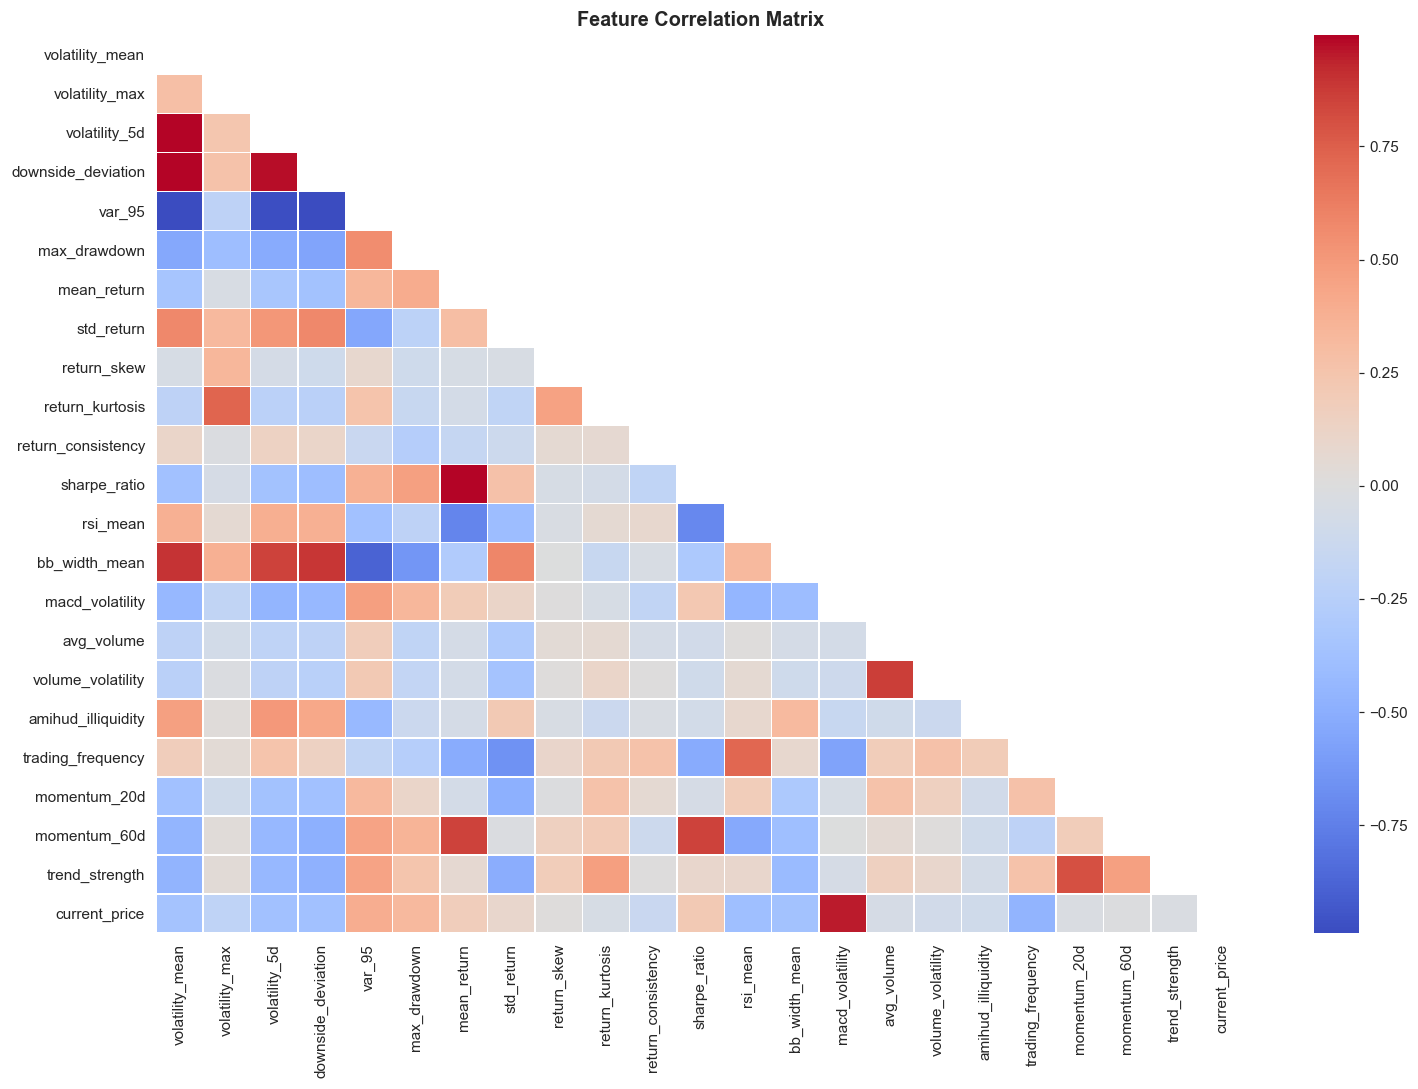

In [4]:
fig, ax = plt.subplots(figsize=(14, 10))
corr = df[NUMERIC_FEATURES].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=0.3, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Preprocessing and PCA

In [5]:
# preprocess() uses CLUSTERING_FEATURES (13 features) by default
X_scaled, meta, scaler = preprocess(df)
X_pca, pca = run_pca(X_scaled, n_components=10)

Preprocessed — shape: (57, 15)
PCA: 10 components explain 99.8% variance


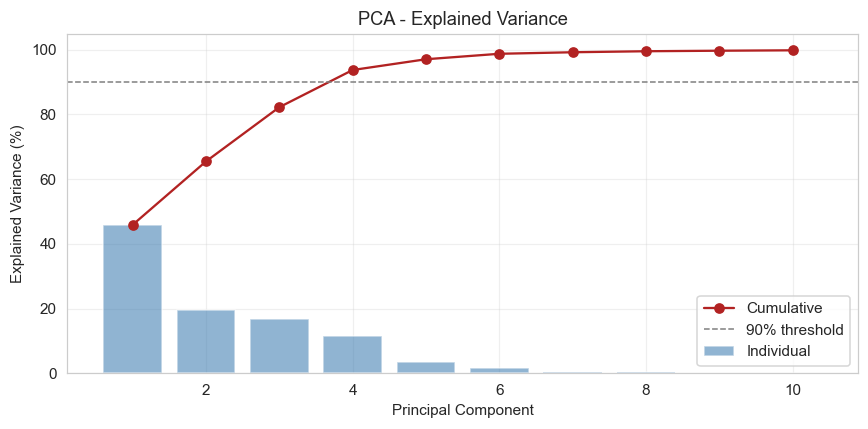

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_pca_variance(pca, ax=ax)
plt.tight_layout()
plt.show()

In [7]:
# Top features driving PC1 and PC2
loadings = pd.DataFrame(
    pca.components_[:2].T,
    index=CLUSTERING_FEATURES,
    columns=['PC1', 'PC2'],
)
print('Top PC1 drivers:')
print(loadings['PC1'].abs().sort_values(ascending=False).head(6))
print('\nTop PC2 drivers:')
print(loadings['PC2'].abs().sort_values(ascending=False).head(6))

Top PC1 drivers:
return_kurtosis       0.785521
return_skew           0.600712
volatility_max        0.103874
amihud_illiquidity    0.069998
sharpe_ratio          0.045765
momentum_60d          0.040901
Name: PC1, dtype: float64

Top PC2 drivers:
sharpe_ratio          0.713939
rsi_mean              0.578960
momentum_60d          0.244953
amihud_illiquidity    0.181827
return_skew           0.154527
trading_frequency     0.101911
Name: PC2, dtype: float64


## 3. Find Optimal Number of Clusters

In [8]:
results, best_k = find_optimal_k(X_pca, k_range=range(2, 9))

Optimal k by silhouette score: 4


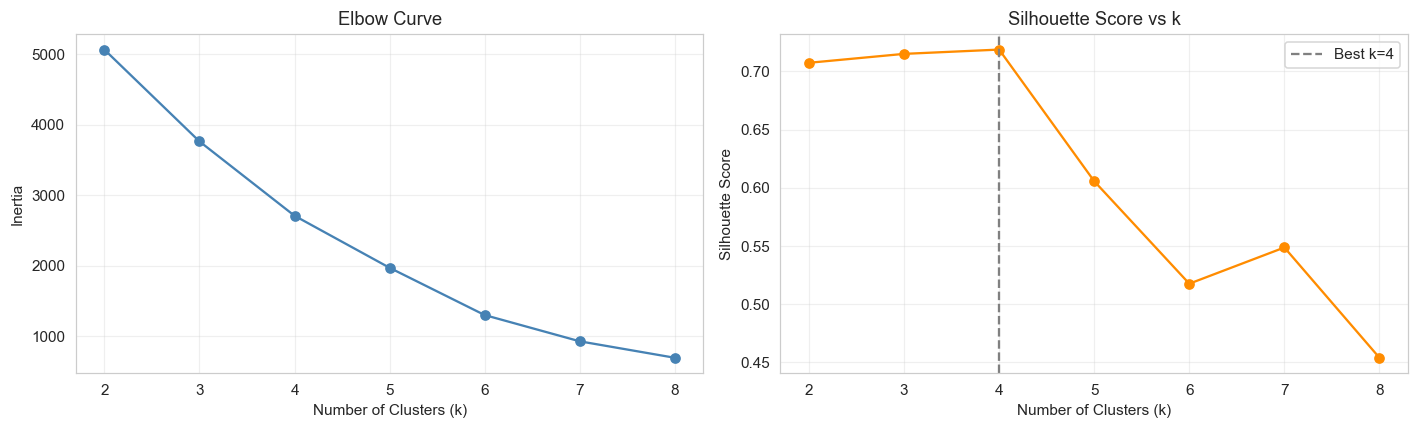

Selected k = 4


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
plot_elbow(results, ax=axes[0])
plot_silhouette_k(results, best_k, ax=axes[1])
plt.tight_layout()
plt.show()
print('Selected k =', best_k)

## 4. Clustering

### 4a. KMeans

In [10]:
km_labels = kmeans_cluster(X_pca, n_clusters=best_k)
metrics_km = evaluate_clustering(X_pca, km_labels, name='KMeans')

KMeans — k=4, inertia=2710.14
  [KMeans] Silhouette=0.7187 | DB=0.4647 | CH=33.7


### 4b. Hierarchical (Ward Linkage)

In [11]:
hc_labels = hierarchical_cluster(X_pca, n_clusters=best_k)
metrics_hc = evaluate_clustering(X_pca, hc_labels, name='Hierarchical')

Hierarchical — k=4, linkage=ward
  [Hierarchical] Silhouette=0.7187 | DB=0.4647 | CH=33.7


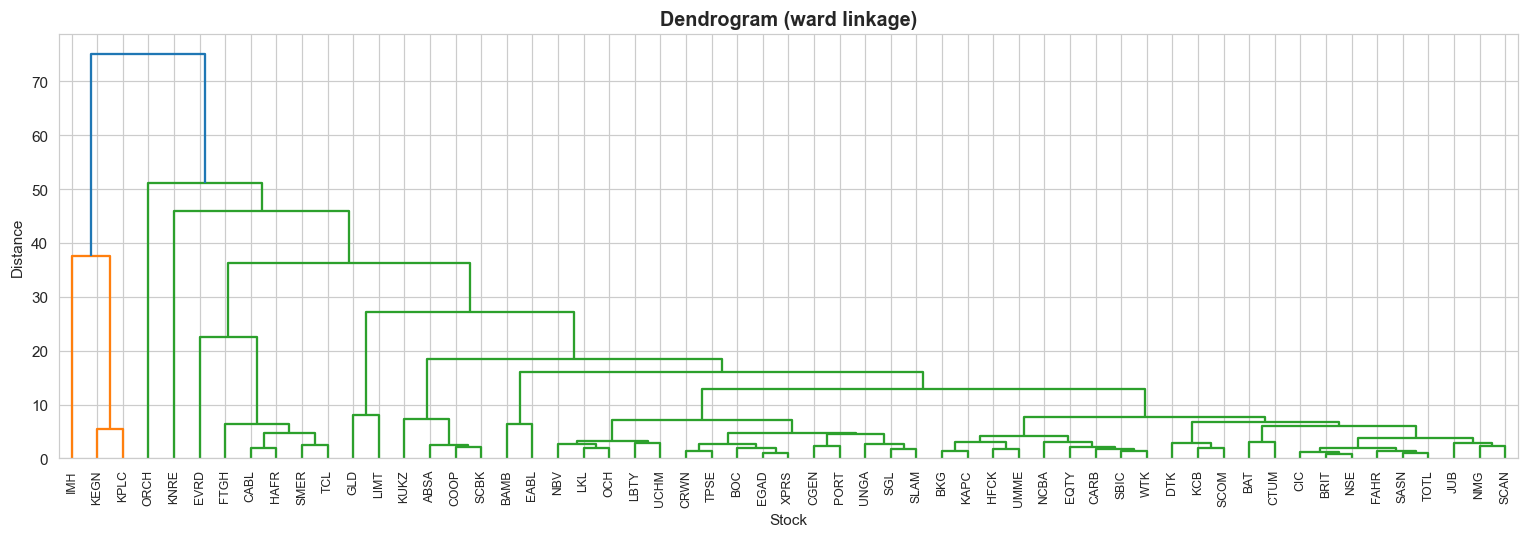

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_dendrogram(X_pca, meta, method='ward', ax=ax)
plt.tight_layout()
plt.show()

### 4c. DBSCAN

In [13]:
db_labels = dbscan_cluster(X_pca, eps=2.0, min_samples=3)
metrics_db = evaluate_clustering(X_pca, db_labels, name='DBSCAN')

DBSCAN — eps=2.0, clusters=2, noise points=31
  [DBSCAN] Silhouette=0.5913 | DB=0.5070 | CH=26.1


## 5. Visualisation — PCA and t-SNE

In [14]:
X_pca2 = X_pca[:, :2]           # first two PCs for 2-D scatter
X_tsne = run_tsne(X_scaled, perplexity=10)

t-SNE embedding shape: (57, 2)


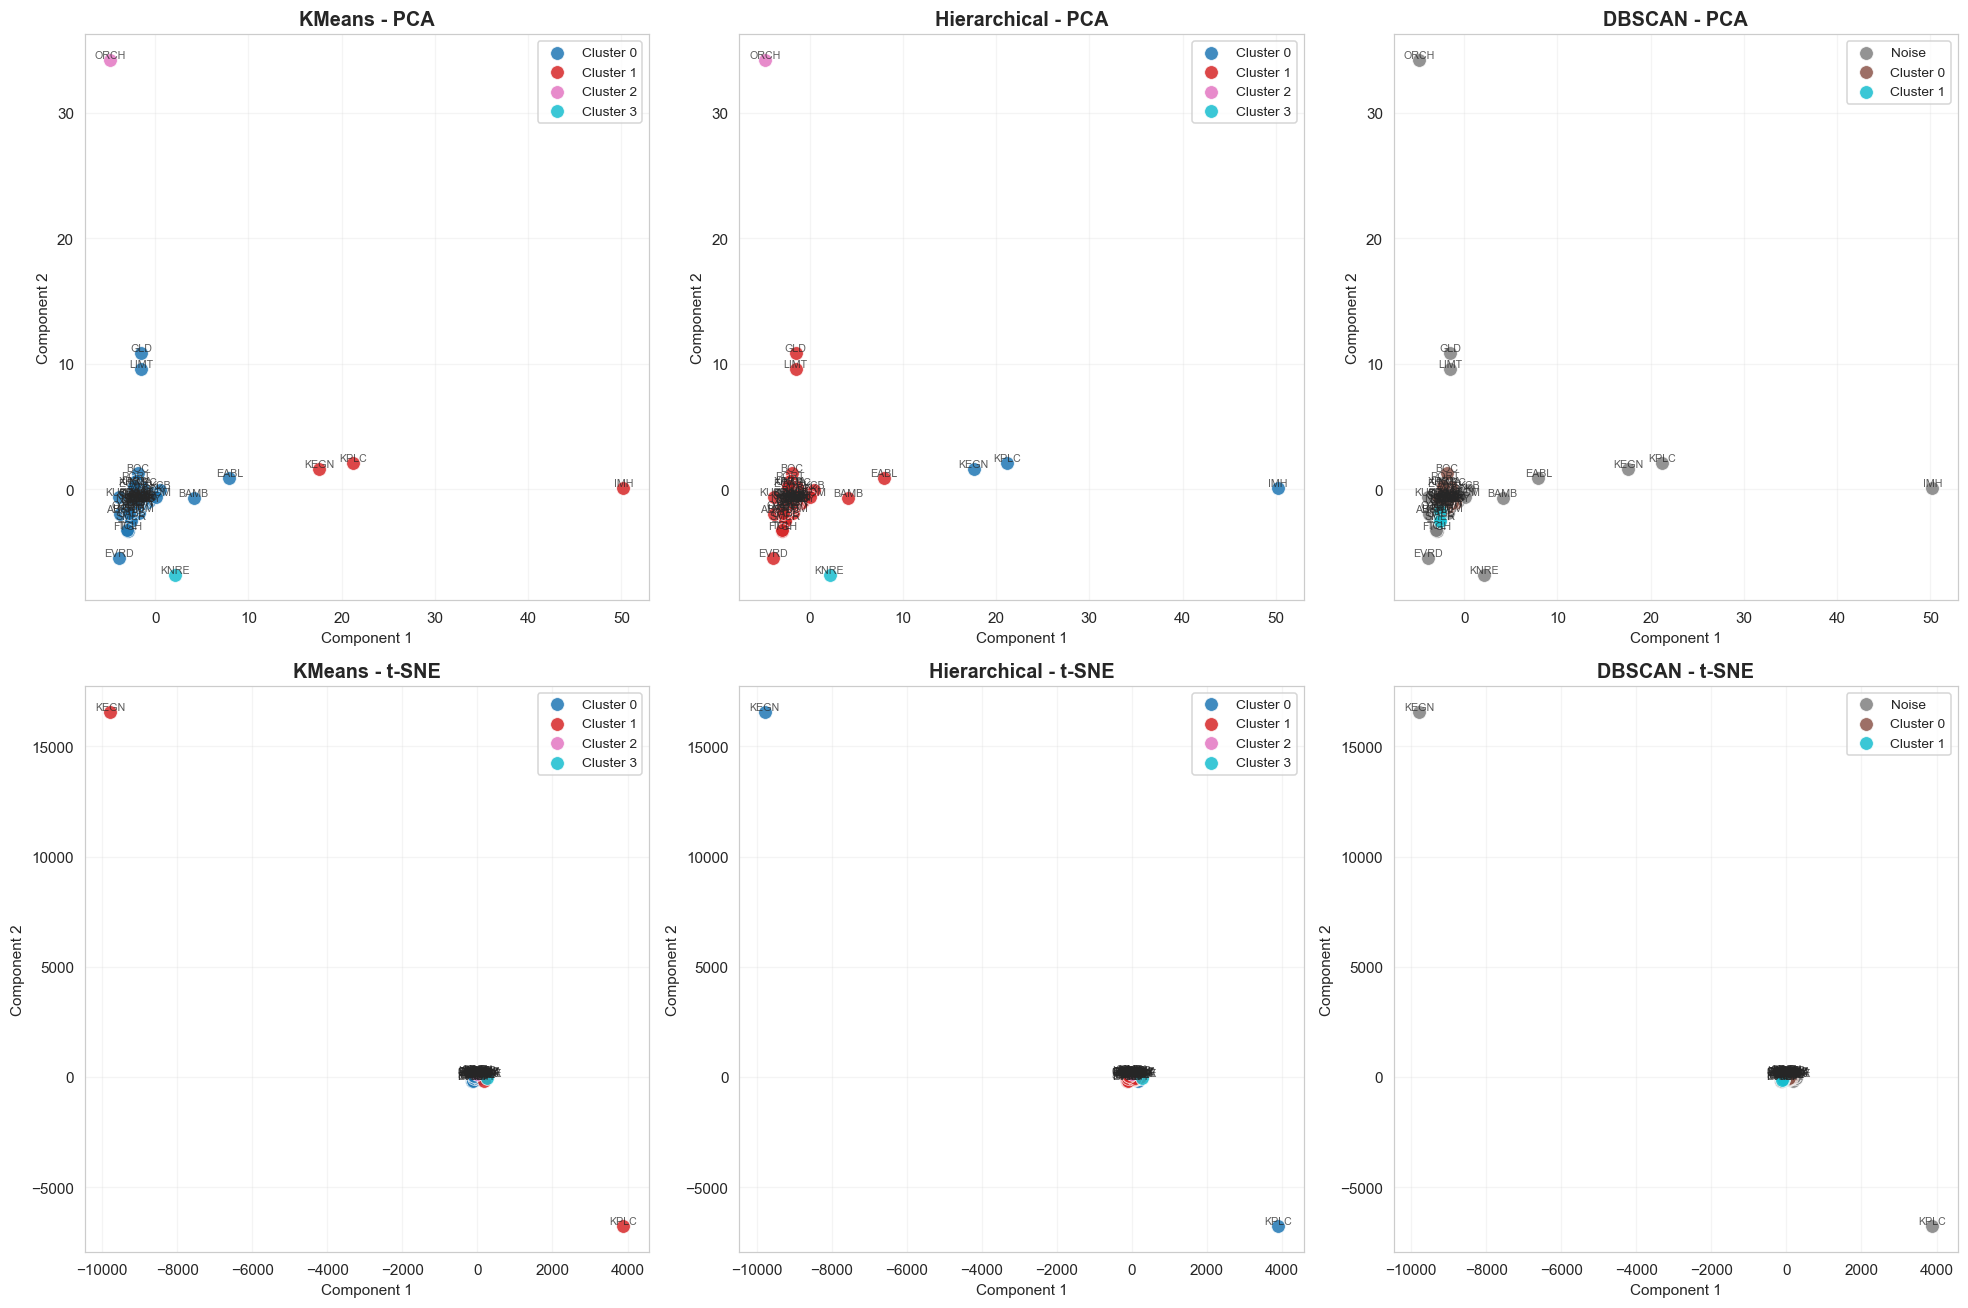

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_clusters_2d(X_pca2, km_labels, meta, title='KMeans - PCA',         ax=axes[0, 0])
plot_clusters_2d(X_pca2, hc_labels, meta, title='Hierarchical - PCA',   ax=axes[0, 1])
plot_clusters_2d(X_pca2, db_labels, meta, title='DBSCAN - PCA',         ax=axes[0, 2])

plot_clusters_2d(X_tsne, km_labels, meta, title='KMeans - t-SNE',       ax=axes[1, 0])
plot_clusters_2d(X_tsne, hc_labels, meta, title='Hierarchical - t-SNE', ax=axes[1, 1])
plot_clusters_2d(X_tsne, db_labels, meta, title='DBSCAN - t-SNE',       ax=axes[1, 2])

plt.tight_layout()
plt.show()

## 6. Cluster Profiles and Sector Composition

In [16]:
df_out = df.copy()
df_out['KMeans_Cluster']       = km_labels
df_out['Hierarchical_Cluster'] = hc_labels
df_out['DBSCAN_Cluster']       = db_labels

profile_features = [
    'volatility_mean', 'downside_deviation', 'max_drawdown',
    'mean_return', 'sharpe_ratio', 'rsi_mean',
    'momentum_20d', 'momentum_60d', 'trend_strength',
    'amihud_illiquidity', 'trading_frequency',
]

In [26]:
df_profile = df_out[profile_features + ['KMeans_Cluster']]
cluster_profiles = df_profile.groupby('KMeans_Cluster').mean()
cluster_profiles['count'] = df_profile['KMeans_Cluster'].value_counts().sort_index()
print(cluster_profiles)

                volatility_mean  downside_deviation  max_drawdown  \
KMeans_Cluster                                                      
0                      0.026776            0.015911     -0.478627   
1                      0.020270            0.010623     -0.552036   
2                      0.003921            0.000639     -0.069767   
3                      0.021732            0.013664     -0.637631   

                mean_return  sharpe_ratio   rsi_mean  momentum_20d  \
KMeans_Cluster                                                       
0                  0.000759      0.018438  47.783312      0.031887   
1                  0.000552      0.013977  47.201416      0.062472   
2                  0.047559      0.886634   7.305277      0.000000   
3                 -0.000173     -0.010154  47.803971      0.113043   

                momentum_60d  trend_strength  amihud_illiquidity  \
KMeans_Cluster                                                     
0                   0.038052

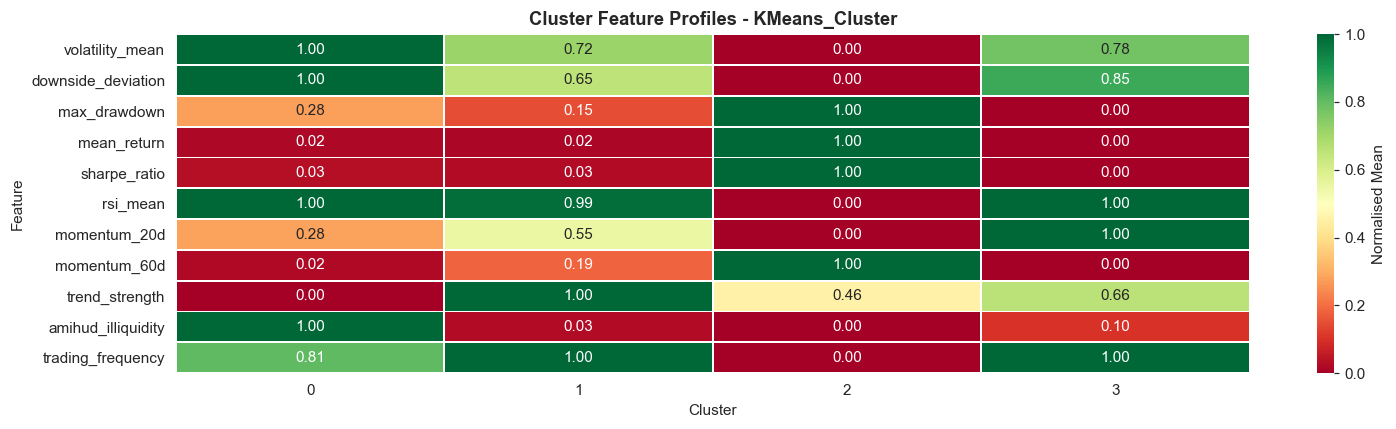

In [17]:
plot_cluster_profiles(df_out, profile_features, method_col='KMeans_Cluster')
plt.tight_layout()
plt.show()

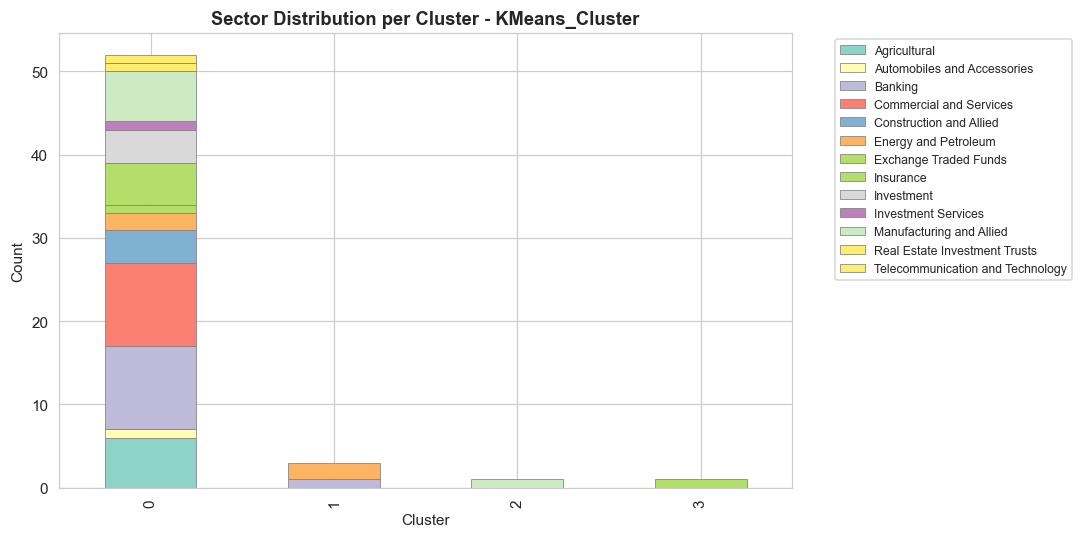

In [18]:
plot_sector_distribution(df_out, method_col='KMeans_Cluster')
plt.show()

## 7. Method Comparison

In [19]:
all_metrics = [m for m in [metrics_km, metrics_hc, metrics_db] if m]
comparison_df = compare_methods(all_metrics)
comparison_df


-- Method Comparison ------------------------------------------
              n_clusters  silhouette  davies_bouldin  calinski_harabasz
method                                                                 
KMeans                 4      0.7187          0.4647            33.7136
Hierarchical           4      0.7187          0.4647            33.7136
DBSCAN                 2      0.5913          0.5070            26.0678


,n_clusters,silhouette,davies_bouldin,calinski_harabasz
method,,,,
KMeans,4,0.7187,0.4647,33.7136
Hierarchical,4,0.7187,0.4647,33.7136
DBSCAN,2,0.5913,0.5070,26.0678


## 8. Cluster Membership Table

In [20]:
summary = (
    df_out[['Stock_code', 'Name', 'Sector',
            'KMeans_Cluster', 'Hierarchical_Cluster', 'DBSCAN_Cluster']]
    .sort_values('KMeans_Cluster')
    .reset_index(drop=True)
)
summary

,Stock_code,Name,Sector,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster
0,ABSA,ABSA Bank Kenya Plc,Banking,0,1,-1
1,LBTY,Liberty Kenya Holdings Ltd,Insurance,0,1,-1
2,LIMT,Limuru Tea Plc,Agricultural,0,1,-1
3,LKL,Longhorn Publishers Plc,Commercial and Services,0,1,0
4,NBV,Nairobi Business Ventures Ltd,Commercial and Services,0,1,-1
5,NCBA,NCBA Group Plc,Banking,0,1,-1
6,NMG,Nation Media Group Plc,Commercial and Services,0,1,-1
7,NSE,Nairobi Securities Exchange Plc,Investment Services,0,1,0
8,OCH,Olympia Capital Holdings Ltd,Investment,0,1,0
9,PORT,East African Portland Cement Ltd,Construction and Allied,0,1,-1


In [21]:
# Per-cluster summary stats (KMeans)
df_out.groupby('KMeans_Cluster')[profile_features].mean().round(4)

,volatility_mean,downside_deviation,max_drawdown,mean_return,sharpe_ratio,rsi_mean,momentum_20d,momentum_60d,trend_strength,amihud_illiquidity,trading_frequency
KMeans_Cluster,,,,,,,,,,,
0,0.0268,0.0159,-0.4786,0.0008,0.0184,47.7833,0.0319,0.0381,0.0187,0.0,0.8152
1,0.0203,0.0106,-0.5520,0.0006,0.0140,47.2014,0.0625,0.3767,0.1567,0.0,0.9983
2,0.0039,0.0006,-0.0698,0.0476,0.8866,7.3053,0.0000,2.0501,0.0816,0.0,0.0425
3,0.0217,0.0137,-0.6376,-0.0002,-0.0102,47.8040,0.1130,-0.0078,0.1093,0.0,1.0000


In [22]:
df_out

,Stock_code,Sector,Name,volatility_mean,volatility_max,volatility_5d,downside_deviation,var_95,max_drawdown,mean_return,...,volume_volatility,amihud_illiquidity,trading_frequency,momentum_20d,momentum_60d,trend_strength,current_price,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster
0,ABSA,Banking,ABSA Bank Kenya Plc,0.012240,0.032507,0.010669,0.007478,-0.017853,-0.236220,0.000743,...,1.206789e+06,3.464928e-09,1.000000,0.168285,0.284698,0.183930,18.05,0,1,-1
1,BAMB,Construction and Allied,Bamburi Cement Ltd,0.023726,0.089329,0.021072,0.013241,-0.030420,-0.514563,0.000901,...,4.414206e+06,1.904103e-08,0.985830,-0.140625,-0.063830,-0.088486,55.00,0,1,-1
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,0.011709,0.027272,0.010182,0.006908,-0.015898,-0.348232,0.000126,...,5.648945e+04,1.622817e-09,0.947368,0.075823,0.094614,0.068561,376.00,0,1,-1
3,BKG,Banking,BK Group Plc,0.028116,0.057793,0.024537,0.016608,-0.041967,-0.392500,0.001923,...,5.454811e+05,0.000000e+00,0.599190,-0.038405,-0.028358,-0.031970,32.55,0,1,0
4,BOC,Manufacturing and Allied,BOC Kenya Plc,0.025316,0.054629,0.019874,0.015212,-0.034998,-0.302949,0.001758,...,7.566827e+04,0.000000e+00,0.406883,-0.002809,0.123418,0.055134,88.75,0,1,0
5,BRIT,Insurance,Britam Holdings Plc,0.023502,0.046395,0.022819,0.013341,-0.035251,-0.516706,0.000109,...,5.581117e+06,8.629420e-08,0.998988,-0.006849,-0.026846,-0.004007,5.80,0,1,0
6,CABL,Construction and Allied,East African Cables Ltd,0.033756,0.055498,0.032813,0.019629,-0.053223,-0.543750,0.000319,...,3.292638e+04,1.321744e-06,0.993927,-0.018182,0.102041,0.031519,1.08,0,1,1
7,CARB,Manufacturing and Allied,Carbacid Investments Plc,0.021577,0.044205,0.019843,0.012372,-0.031076,-0.304979,0.000820,...,2.800011e+05,4.517936e-08,0.988866,0.132432,-0.079121,0.017608,20.95,0,1,0
8,CGEN,Automobiles and Accessories,Car and General (K) Ltd,0.035478,0.082397,0.030078,0.021095,-0.056548,-0.751974,0.000883,...,5.138129e+03,0.000000e+00,0.577935,0.080760,-0.107843,0.063457,22.75,0,1,0
9,CIC,Insurance,CIC Insurance Group Ltd,0.025695,0.053972,0.024087,0.014594,-0.039957,-0.504425,0.000364,...,3.489579e+05,1.024611e-07,1.000000,0.038647,0.053922,0.005770,2.15,0,1,0
